# 自然语言推断：微调BERT
:label:`sec_natural-language-inference-bert`

在本章的前面几节中，我们已经为SNLI数据集（ :numref:`sec_natural-language-inference-and-dataset`）上的自然语言推断任务设计了一个基于注意力的结构（ :numref:`sec_natural-language-inference-attention`）。现在，我们通过微调BERT来重新审视这项任务。正如在 :numref:`sec_finetuning-bert`中讨论的那样，自然语言推断是一个序列级别的文本对分类问题，而微调BERT只需要一个额外的基于多层感知机的架构，如 :numref:`fig_nlp-map-nli-bert`中所示。

![将预训练BERT提供给基于多层感知机的自然语言推断架构](../img/nlp-map-nli-bert.svg)
:label:`fig_nlp-map-nli-bert`

在本节中，我们将下载一个预训练好的小版本的BERT，然后对其进行微调，以便在SNLI数据集上进行自然语言推断。


In [1]:
import json
import multiprocessing
import os
import paddle
from paddle import nn
from d2l import paddle as d2l

d2l.DATA_HUB['SNLI'] = (
    'https://nlp.stanford.edu/projects/snli/snli_1.0.zip',
    '9fcde07509c7e87ec61c640c1b2753d9041758e4')

data_dir = d2l.download_extract('SNLI')

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


## [**加载预训练的BERT**]

我们已经在 :numref:`sec_bert-dataset`和 :numref:`sec_bert-pretraining`WikiText-2数据集上预训练BERT（请注意，原始的BERT模型是在更大的语料库上预训练的）。正如在 :numref:`sec_bert-pretraining`中所讨论的，原始的BERT模型有数以亿计的参数。在下面，我们提供了两个版本的预训练的BERT：“bert.base”与原始的BERT基础模型一样大，需要大量的计算资源才能进行微调，而“bert.small”是一个小版本，以便于演示。


In [2]:
d2l.DATA_HUB['bert_small'] = ('https://paddlenlp.bj.bcebos.com/models/bert.small.paddle.zip', '9fcde07509c7e87ec61c640c1b277509c7e87ec6153d9041758e4')

d2l.DATA_HUB['bert_base'] = ('https://paddlenlp.bj.bcebos.com/models/bert.base.paddle.zip', '9fcde07509c7e87ec61c640c1b27509c7e87ec61753d9041758e4')

两个预训练好的BERT模型都包含一个定义词表的“vocab.json”文件和一个预训练参数的“pretrained.params”文件。我们实现了以下`load_pretrained_model`函数来[**加载预先训练好的BERT参数**]。


In [3]:
def load_pretrained_model(pretrained_model, num_hiddens, ffn_num_hiddens,
                          num_heads, num_layers, dropout, max_len, devices):
    data_dir = d2l.download_extract(pretrained_model)
    # 定义空词表以加载预定义词表
    vocab = d2l.Vocab()
    vocab.idx_to_token = json.load(open(os.path.join(data_dir,
        'vocab.json')))
    vocab.token_to_idx = {token: idx for idx, token in enumerate(
        vocab.idx_to_token)}
    bert = d2l.BERTModel(len(vocab), num_hiddens, norm_shape=[256],
                         ffn_num_input=256, ffn_num_hiddens=ffn_num_hiddens,
                         num_heads=4, num_layers=2, dropout=0.2,
                         max_len=max_len, key_size=256, query_size=256,
                         value_size=256, hid_in_features=256,
                         mlm_in_features=256, nsp_in_features=256)
    # 加载预训练BERT参数
    bert.set_state_dict(paddle.load(os.path.join(data_dir,
                                                 'pretrained.pdparams')))

    return bert, vocab

为了便于在大多数机器上演示，我们将在本节中加载和微调经过预训练BERT的小版本（“bert.mall”）。在练习中，我们将展示如何微调大得多的“bert.base”以显著提高测试精度。


In [4]:
devices = d2l.try_all_gpus()
bert, vocab = load_pretrained_model(
    'bert_small', num_hiddens=256, ffn_num_hiddens=512, num_heads=4,
    num_layers=2, dropout=0.1, max_len=512, devices=devices)

正在从https://paddlenlp.bj.bcebos.com/models/bert.small.paddle.zip下载./data/bert.small.paddle.zip...


W0307 23:26:25.723093  3677 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 10.1, Runtime API Version: 10.1
W0307 23:26:25.726963  3677 device_context.cc:465] device: 0, cuDNN Version: 7.6.


## [**微调BERT的数据集**]

对于SNLI数据集的下游任务自然语言推断，我们定义了一个定制的数据集类`SNLIBERTDataset`。在每个样本中，前提和假设形成一对文本序列，并被打包成一个BERT输入序列，如 :numref:`fig_bert-two-seqs`所示。回想 :numref:`subsec_bert_input_rep`，片段索引用于区分BERT输入序列中的前提和假设。利用预定义的BERT输入序列的最大长度（`max_len`），持续移除输入文本对中较长文本的最后一个标记，直到满足`max_len`。为了加速生成用于微调BERT的SNLI数据集，我们使用4个工作进程并行生成训练或测试样本。


In [5]:
class SNLIBERTDataset(paddle.io.Dataset):
    def __init__(self, dataset, max_len, vocab=None):
        all_premise_hypothesis_tokens = [[
            p_tokens, h_tokens] for p_tokens, h_tokens in zip(
            *[d2l.tokenize([s.lower() for s in sentences])
              for sentences in dataset[:2]])]

        self.labels = paddle.to_tensor(dataset[2])
        self.vocab = vocab
        self.max_len = max_len
        (self.all_token_ids, self.all_segments,
         self.valid_lens) = self._preprocess(all_premise_hypothesis_tokens)
        print('read ' + str(len(self.all_token_ids)) + ' examples')

    def _preprocess(self, all_premise_hypothesis_tokens):
        #pool = multiprocessing.Pool(1)  # 使用4个进程
        #out = pool.map(self._mp_worker, all_premise_hypothesis_tokens)
        out = []
        for i in all_premise_hypothesis_tokens:
            tempOut = self._mp_worker(i)
            out.append(tempOut)
        
        all_token_ids = [
            token_ids for token_ids, segments, valid_len in out]
        all_segments = [segments for token_ids, segments, valid_len in out]
        valid_lens = [valid_len for token_ids, segments, valid_len in out]
        return (paddle.to_tensor(all_token_ids, dtype='int64'),
                paddle.to_tensor(all_segments, dtype='int64'),
                paddle.to_tensor(valid_lens))

    def _mp_worker(self, premise_hypothesis_tokens):
        p_tokens, h_tokens = premise_hypothesis_tokens
        self._truncate_pair_of_tokens(p_tokens, h_tokens)
        tokens, segments = d2l.get_tokens_and_segments(p_tokens, h_tokens)
        token_ids = self.vocab[tokens] + [self.vocab['<pad>']] \
                             * (self.max_len - len(tokens))
        segments = segments + [0] * (self.max_len - len(segments))
        valid_len = len(tokens)
        return token_ids, segments, valid_len

    def _truncate_pair_of_tokens(self, p_tokens, h_tokens):
        # 为BERT输入中的'<CLS>'、'<SEP>'和'<SEP>'词元保留位置
        while len(p_tokens) + len(h_tokens) > self.max_len - 3:
            if len(p_tokens) > len(h_tokens):
                p_tokens.pop()
            else:
                h_tokens.pop()

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx]), self.labels[idx]

    def __len__(self):
        return len(self.all_token_ids)

下载完SNLI数据集后，我们通过实例化`SNLIBERTDataset`类来[**生成训练和测试样本**]。这些样本将在自然语言推断的训练和测试期间进行小批量读取。


In [6]:
# 如果出现显存不足错误，请减少“batch_size”。在原始的BERT模型中，max_len=512
batch_size, max_len, num_workers = 512, 128, d2l.get_dataloader_workers()
data_dir = d2l.download_extract('SNLI')
train_set = SNLIBERTDataset(d2l.read_snli(data_dir, True), max_len, vocab)
test_set = SNLIBERTDataset(d2l.read_snli(data_dir, False), max_len, vocab)
train_iter = paddle.io.DataLoader(train_set, batch_size=batch_size, shuffle=True, return_list=True)
test_iter = paddle.io.DataLoader(test_set, batch_size=batch_size, return_list=True)

read 549367 examples
read 9824 examples


## 微调BERT

如 :numref:`fig_bert-two-seqs`所示，用于自然语言推断的微调BERT只需要一个额外的多层感知机，该多层感知机由两个全连接层组成（请参见下面`BERTClassifier`类中的`self.hidden`和`self.output`）。[**这个多层感知机将特殊的“&lt;cls&gt;”词元**]的BERT表示进行了转换，该词元同时编码前提和假设的信息(**为自然语言推断的三个输出**)：蕴涵、矛盾和中性。


In [7]:
class BERTClassifier(nn.Layer):
    def __init__(self, bert):
        super(BERTClassifier, self).__init__()
        self.encoder = bert.encoder
        self.hidden = bert.hidden
        self.output = nn.Linear(256, 3)

    def forward(self, inputs):
        tokens_X, segments_X, valid_lens_x = inputs
        encoded_X = self.encoder(tokens_X, segments_X, valid_lens_x)
        return self.output(self.hidden(encoded_X[:, 0, :]))

在下文中，预训练的BERT模型`bert`被送到用于下游应用的`BERTClassifier`实例`net`中。在BERT微调的常见实现中，只有额外的多层感知机（`net.output`）的输出层的参数将从零开始学习。预训练BERT编码器（`net.encoder`）和额外的多层感知机的隐藏层（`net.hidden`）的所有参数都将进行微调。


In [8]:
net = BERTClassifier(bert)

回想一下，在 :numref:`sec_bert`中，`MaskLM`类和`NextSentencePred`类在其使用的多层感知机中都有一些参数。这些参数是预训练BERT模型`bert`中参数的一部分，因此是`net`中的参数的一部分。然而，这些参数仅用于计算预训练过程中的遮蔽语言模型损失和下一句预测损失。这两个损失函数与微调下游应用无关，因此当BERT微调时，`MaskLM`和`NextSentencePred`中采用的多层感知机的参数不会更新（陈旧的，staled）。

为了允许具有陈旧梯度的参数，标志`ignore_stale_grad=True`在`step`函数`d2l.train_batch_ch13`中被设置。我们通过该函数使用SNLI的训练集（`train_iter`）和测试集（`test_iter`）对`net`模型进行训练和评估。。由于计算资源有限，[**训练**]和测试精度可以进一步提高：我们把对它的讨论留在练习中。


loss 0.405, train acc 0.840, test acc 0.772
3972.4 examples/sec on [CUDAPlace(0)]


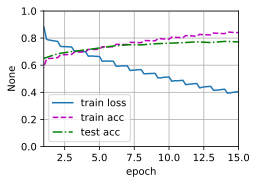

In [9]:
lr, num_epochs = 1e-4, 15
trainer = paddle.optimizer.Adam(learning_rate=lr, parameters=net.parameters())
loss = nn.CrossEntropyLoss(reduction='none')
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
    devices)

## 小结

* 我们可以针对下游应用对预训练的BERT模型进行微调，例如在SNLI数据集上进行自然语言推断。
* 在微调过程中，BERT模型成为下游应用模型的一部分。仅与训练前损失相关的参数在微调期间不会更新。

## 练习

1. 如果您的计算资源允许，请微调一个更大的预训练BERT模型，该模型与原始的BERT基础模型一样大。修改`load_pretrained_model`函数中的参数设置：将“bert.mall”替换为“bert.base”，将`num_hiddens=256`、`ffn_num_hiddens=512`、`num_heads=4`和`num_layers=2`的值分别增加到768、3072、12和12。通过增加微调迭代轮数（可能还会调优其他超参数），你可以获得高于0.86的测试精度吗？
1. 如何根据一对序列的长度比值截断它们？将此对截断方法与`SNLIBERTDataset`类中使用的方法进行比较。它们的利弊是什么？


[Discussions](https://discuss.d2l.ai/t/5718)
